# Diffusion Models from Scratch

Sometimes it is helpful to consider the simplest possible version of something to better understand how it works. We're going to try that in this notebook, beginning with a 'toy' diffusion model to see how the different pieces work, and then examining how they differ from a more complex implementation. 

We will look at 
- The corruption process (adding noise to data)
- What a UNet is, and how to implement an extremely minimal one from scratch
- Diffusion model training
- Sampling theory

Then we'll compare our versions with the diffusers DDPM implementation, exploring
- Improvements over our mini UNet
- The DDPM noise schedule
- Differences in training objective
- Timestep conditioning
- Sampling approaches

There're 8 tasks. Task 6 and Task 7 are challenging.

## Setup and Imports:

In [ ]:
%pip install -q diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from typing import Dict, Tuple
from tqdm import tqdm 
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

## The Data

Here we're going to test things with a very small dataset: mnist. If you'd like to give the model a slightly harder challenge without changing anything else, torchvision.datasets.FashionMNIST should work as a drop-in replacement. 

In [ ]:
dataset = torchvision.datasets.MNIST(root='dataset', train=True, download=False, transform=torchvision.transforms.ToTensor())

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

Each image is a greyscale 28px by 28px drawing of a digit, with values ranging from 0 to 1.

## The Corruption Process

Pretend you haven't read any diffusion model papers, but you know the process involves adding noise. How would you do it?

We probably want an easy way to control the amount of corruption. So what if we take in a parameter for the `amount` of noise to add.

If amount = 0, we get back the input without any changes. If amount gets up to 1, we get back noise with no trace of the input x. By mixing the input with noise this way, we keep the output in the same range (0 to 1).

We can implement this fairly easily (just watch the shapes so you don't get burnt by broadcasting rules).

**Task 1:** Fill out the corrupted image in `return`.

In [ ]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works

  # TODO 
  # Task 1: Return the corrupted image
  # return 
  ### End of Task 1 ### 

And looking at the results visually to see that it works as expected:

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

As noise amount approaches one, our data begins to look like pure random noise. But for most noise amounts, you can guess the digit fairly well. Do you think this is optimal?

## The Model

We'd like a model that takes in a 28px noisy images and outputs a prediction of the same shape. A popular choice here is an architecture called a UNet. [Originally invented for segmentation tasks in medical imagery](https://arxiv.org/abs/1505.04597), a UNet consists of a 'constricting path' through which data is compressed down and an 'expanding path' through which it expands back up to the original dimension (similar to an autoencoder) but also features skip connections that allow for information and gradients to flow across at different levels. 

Some UNets feature complex blocks at each stage, but for this toy demo we'll build a minimal example that takes in a one-channel image and passes it through three convolutional layers on the down path (the down_layers in the diagram and code) and three on the up path, with skip connections between the down and up layers. We'll use max pooling for downsampling and `nn.Upsample` for upsampling rather than relying on learnable layers like more complex UNets. Here is the rough architecture showing the number of channels in the output of each layer:

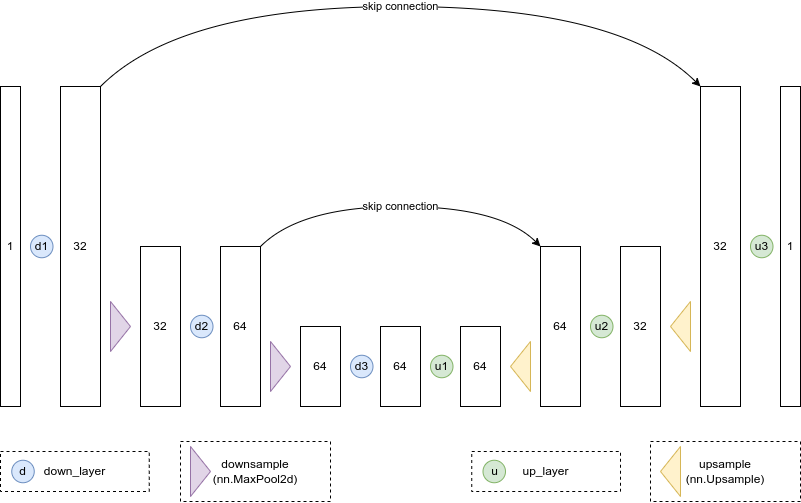


This is what that looks like in code. Make sure that you understand the implementation:


In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

We can verify that the output shape is the same as the input, as we expect:

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

This network has just over 300,000 parameters:

In [ ]:
sum([p.numel() for p in net.parameters()])

You can explore changing the number of channels in each layer or swapping in different architectures if you want.

## Training the network

We can now have a go at training the network. 
- Get a batch of data
- Corrupt it by random amounts
- Feed it through the model
- Compare the model predictions with the clean images to calculate our loss
- Update the model's parameters accordingly.

Feel free to modify this and see if you can get it working better!
**N.B.:** It takes ~8min for 3 epochs. You can set a smaller one if you'd hurry.

**Task 2:** Implement the loss function.

**Task 3:** Explain what the input and the output of the net are.

**Answer Task 3:** 

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
# TODO
# Task 2: Fill out the loss:
# loss_fn = 
### End of Task 2 ### 

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU

        # TODO:
        # Task 3: Explain what the input and the output of the net are.
        noise_amount = torch.rand(x.shape[0]).to(device)
        noise_amount = noise_amount.to(device) 
        noisy_x = corrupt(x, noise_amount)
        pred = net(noisy_x)
        ### End of Task ### 

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

We can try to see what the model predictions look like by grabbing a batch of data, corrupting it by different amounts and then seeing the models predictions:

In [ ]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

You can see that for the lower amounts the predictions are pretty good! But as the level gets very high there is less for the model to work with, and by the time we get to amount=1 it outputs a blurry mess close to the mean of the dataset to try and hedge its bets on what the output might look like...

## Sampling

If our predictions at high noise levels aren't very good, how do we generate images?

**Task 4:** Explain how an image is generated with the sampling below.

**Answer Task 4:** 

In [ ]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting

    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor 

    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

We can split the process up into more steps, and hope for better images that way:

In [ ]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Not great, but there are some recognizable digits there! You can experiment with training for longer (say, 10 or 20 epochs) and tweaking model config, learning rate, optimizer and so on. Also, don't forget that fashionMNIST is a one-line replacement if you want a slightly harder dataset to try.

## Comparison To DDPM

In this section we'll take a look at how our toy implementation differs from the approach used in the other notebook ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)), which is based on the DDPM paper.

We'll see that


*   The diffusers `UNet2DModel` is a bit more advanced than our BasicUNet
*   The corruption process in handled differently
*   The training objective is different, involving predicting the noise rather than the denoised image
*   The model is conditioned on the amount of noise present via timestep conditioning, where t is passed as an additional argument to the forward method.
*   There are a number of different sampling strategies available, which should work better than our simplistic version above.

There have been a number of improvements suggested since the DDPM paper came out, but this example is hopefully instructive as to the different available design decisions. Once you've read through this, you may enjoy diving into the paper ['Elucidating the Design Space of Diffusion-Based Generative Models'](https://arxiv.org/abs/2206.00364) which explores all of these components in some detail and makes new recommendations for how to get the best performance. 

If all of this is too technical or intimidating, don't worry! Feel free to skip the rest of this notebook or save it for a rainy day. 




### The UNet

The diffusers UNet2DModel model has a number of improvements over our basic UNet above:

*   GroupNorm applies group normalization to the inputs of each block
*   Dropout layers for smoother training
*   Multiple resnet layers per block (if layers_per_block isn't set to 1)
*   Attention (usually used only at lower resolution blocks)
*   Conditioning on the timestep. 
*   Downsampling and upsampling blocks with learnable parameters

Let's create and inspect a UNet2DModel:



In [ ]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)


As you can see, a little more going on! It also has significantly more parameters than our BasicUNet:

In [ ]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

We can replicate the training shown above using this model in place of our original one. We need to pass both x and timestep to the model (here I always pass t=0 to show that it works without this timestep conditioning and to keep the sampling code easy, but you can also try feeding in `(amount*1000)` to get a timestep equivalent from the corruption amount). Lines changed are shown with `#<<<` if you want to inspect the code.

**N.B.:** It takes around 8 min for 3 epochs in the block below.

In [ ]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

This looks quite a bit better than our first set of results! You can explore tweaking the unet configuration or training for longer to get even better performance. 

### From now on, we will implement the DDPM algorithm based on the paper.


**Task 5:** In the following `ddpm_schedules` function, rename the variables from `a` to `h` with the names in the return dictionary. Note that `beta_t` is also one of the variable names but will not returned (as an intermediate variable). 

In [ ]:
def ddpm_schedules(beta1: float, beta2: float, T: int):
    """
    See Section 4 Experiments for beta1 (beta_1) and beta2 (beta_T)
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    # TODO
    # Task 5: change the variable names a-h to the names in the return dict.
    a = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    b = torch.sqrt(a)
    c = 1 - a
    d = torch.cumsum(torch.log(c), dim=0).exp() # for stability

    e = torch.sqrt(d)
    f = 1 / torch.sqrt(c)

    g = torch.sqrt(1 - d)
    h = (1 - c) / g
    ### End of Task 5 ###

    return {
        # As intermediate variables:
        # beta_t (it won't be returned)
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t} also denoted as \sigma_t
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

print(ddpm_schedules(1e-4, 0.02, 2))

Check your results with an example to the expected ones:
```python
{'alpha_t':         tensor([0.9999, 0.9900, 0.9800]), 
'oneover_sqrta':    tensor([1.0001, 1.0051, 1.0102]), 
'sqrt_beta_t':      tensor([0.0100, 0.1002, 0.1414]), 
'alphabar_t':       tensor([0.9999, 0.9899, 0.9701]), 
'sqrtab':           tensor([0.9999, 0.9949, 0.9849]), 
'sqrtmab':          tensor([0.0100, 0.1007, 0.1730]), 
'mab_over_sqrtmab': tensor([0.0100, 0.0998, 0.1156])}
```

**Task 6:** We will implement `Algorithm 1` from the paper in the `forward` function.

Hints (There're certainly various ways to implement it): 
- `torch.randint()`, `torch.randn_like()`, `torch.randn()`
- You can access all the scheduler's variables by e.g. `self.alpha_t`
- You can sample from e.g. `self.alpha_t` with a vector of timesteps by `self.alpha_t[_ts]`
- To broadcast a vector to a pseudo tensor for multiplication, you can e.g. do `vector_to_tensor[_ts , None, None, None]`
- Don't forget to send the variables to GPU by `some_tensor.to(device)`

**Task 7:** We will implement `Algorithm 2` from the paper in the `ddpm_sample` function.

In [ ]:

class DDPM(nn.Module):
    def __init__(
        self,
        eps_model: nn.Module,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super(DDPM, self).__init__()
        self.eps_model = eps_model

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Makes forward diffusion x_t, and tries to guess epsilon value from x_t using eps_model.
        This implements Algorithm 1 in the paper.
        """
        
        # TODO
        # Task 6:
        # _ts =  # t ~ Uniform(0, n_T). A vector of `batch_size` random timesteps.
        # eps =  # eps ~ N(0, 1)
        # x_t =  # Check Equation 14
        ### End of Task 6 ###

        pred_eps = self.eps_model(x_t, _ts / self.n_T).sample
        return self.criterion(eps, pred_eps)

    def ddpm_sample(self, n_sample: int, size, device) -> torch.Tensor:

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in range(self.n_T, 0, -1):
        
            # TODO
            # Task 7: To fill out z, pred_eps, x_i below.
            if i > 1:
                # z = # sampled from Gaussian
            else: 
                z = 0

            # pred_eps =  # predicted from the network 
            # x_i =  # See Algorithm 2. Note that \sigma_t = \sqrt{\beta_t}
            ### End of Task 7 ###

        return x_i


Now, we have DDPM. Let's train the model again.

In [ ]:
# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)
ddpm = DDPM(eps_model=net, betas=(1e-4, 0.02), n_T=200) # See Section 4 (beta_1 and beta_T)
ddpm.to(device)

tf = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.,), (1.0))]
)

dataset = torchvision.datasets.MNIST(root='/home/praktikum/MLLab/src/S7/mnist/', train=True, download=False, transform=tf)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optim = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
n_epoch = 3
for i in range(n_epoch):
    ddpm.train()

    pbar = tqdm(dataloader)
    for x, _ in pbar:
        optim.zero_grad()
        x = x.to(device)
        loss = ddpm(x)
        loss.backward()
        pbar.set_description(f"loss: {loss.item():.4f}")
        optim.step()


Visualize the results. They might look like okay or not, but based on experiments with various datasets and various parameters (model architecture, all kinds of hyperparameters, etc.), the authors find that predicting the errors is advantageous.

In [ ]:

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

ddpm.eval()
with torch.no_grad():
  xh = ddpm.ddpm_sample(64, (1,28,28), device)

axs[1].imshow(torchvision.utils.make_grid(xh.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');


### From now on, we will use the library `diffusers`

We will first have a recap of the corruption process (adding noise). Then we will check the more advanced schedulers.

### The Corruption Process

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us (uncomment the next cell to check out the code). We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:


In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

Initially, the noisy x is mostly x (sqrt_alpha_prod ~= 1) but over time the contribution of x drops and the noise component increases. Unlike our linear mix of x and noise according to `amount`, this one gets noisy relatively quickly. We can visualize this on some data:

In [ ]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X')

Again, it takes some time to finish the training. It is not expected to have the perfect results in today's session (which is not feasible in terms of training speed and not the purpose of the implementation from the tutorials), but hopefully you won't feel nervous when you're adopting a more advanced implementation of diffusion model!

In [ ]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
model.to(device)

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(tqdm(train_dataloader)):
        clean_images = batch[0].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()


    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

(Optional): Plot some examples of the new trained model

In [ ]:
input = torch.randn((64,1,28,28), device=device)

for t in noise_scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
        prev_noisy_sample = noise_scheduler.step(noisy_residual, t, input).prev_sample
        input = prev_noisy_sample
  
plt.imshow(torchvision.utils.make_grid(input.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
plt.title('Generated Samples')

### Training Objective

In our toy example, we had the model try to predict the denoised image. In DDPM and many other diffusion model implementations, the model predicts the noise used in the corruption process (before scaling, so unit variance noise). In code, it looks something like:

```python
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # noise as the target
```

You may think that predicting the noise (from which we can derive what the denoised image looks like) is equivalent to just predicting the denoised image directly. So why favour one over the other - is it just for mathematical convenience?

It turns out there's another subtlety here. We compute the loss across different (randomly chosen) timesteps during training. These different objectives will lead to different 'implicit weighting' of these losses, where predicting the noise puts more weight on lower noise levels. You can pick more complex objectives to change this 'implicit loss weighting'. Or perhaps you choose a noise schedule that will result in more examples at a higher noise level. Perhaps you have the model predict a 'velocity' v which we define as being a combination of both the image and the noise dependent on the noise level (see 'PROGRESSIVE DISTILLATION FOR FAST SAMPLING OF DIFFUSION MODELS'). Perhaps you have the model predict the noise but then scale the loss by some factor dependent on the amount of noise based on a bit of theory (see 'Perception Prioritized Training of Diffusion Models') or based on experiments trying to see what noise levels are most informative to the model (see 'Elucidating the Design Space of Diffusion-Based Generative Models'). TL;DR: choosing the objective has an effect on model performance, and research in ongoing into what the 'best' option is.

At the moment, predicting the noise (epsilon or eps you'll see in some places) is the favoured approach but over time we will likely see other objectives supported in the library and used in different situations. 



### Timestep Conditioning

The UNet2DModel takes in both x and timestep. The latter is turned into an embedding and fed into the model in a number of places. 

The theory behind this is that by giving the model information about what the noise level is, it can better perform its task. While it is possible to train a model without this timestep conditioning, it does seem to help performance in some cases and most implementations include it, at least in the current literature. 

### Sampling

Given a model that estimates the noise present in a noisy input (or predicts the denoised version), how do we produce new images?

We could feed in pure noise, and hope that the model predicts a good image as the denoised version in one step. However, as we saw in the experiments above, this doesn't usually work well. So, instead, we take a number of smaller steps based on the model prediction, iteratively removing a little bit of the noise at a time.

Exactly how we take these steps depends on the sampling method used. We won't go into the theory too deeply, but some key design questions are:
- How large of a step should you take? In other words, what 'noise schedule' should you follow?
- Do you use only the model's current prediction to inform the update step (like DDPM, DDIM and many others)? Do you evaluate the model several times to estimate higher-order gradients for a larger, more accurate step (higher-order methods and some discrete ODE solvers)? Or do you keep a history of past predictions to try and better inform the current update step (linear multi-step and ancestral samplers)? 
- Do you add in additional noise (sometimes called churn) to add more stochasticity (randomness) to the sampling process, or do you keep it completely deterministic? Many samplers control this with a parameter (such as 'eta' for DDIM samplers) so that the user can choose.

Research on sampling methods for diffusion models is rapidly evolving, and more and more methods for finding good solutions in fewer steps are being proposed. The brave and curious might find it interesting to browse through the code of the different implementations available in the diffusers library [here](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers) or check out the [docs](https://huggingface.co/docs/diffusers/api/schedulers/overview) which often link to the relevant papers.

## Final Remarks

Hopefully this has been a helpful way to look at diffusion models from a slightly different angle. 

Part of this notebook was written for this Hugging Face course by Jonathan Whitaker, and overlaps with a [version included in his own course](https://johnowhitaker.github.io/tglcourse/dm1.html), 'The Generative Landscape'. Check that out if you'd like to see this basic example extended with noise and class conditioning. Questions or bugs can be communicated through GitHub issues or via Discord. You are also welcome to reach out via Twitter [@johnowhitaker](https://twitter.com/johnowhitaker). We also used codes from https://github.com/cloneofsimo/minDiffusion. 

As suggested in the preparation materials, a line of tutorials from Hugging Face is great: https://github.com/huggingface/diffusion-models-class/tree/main. E.g. in unit3, you can play around the stable diffusion and generate cool pictures with texts!

Contributor(s): Yuli Wu